Training on the Lall dataset.

In [1]:
import torch
import skimage as ski
import numpy as np
from torch.utils.data import Dataset
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# Data Loading

In [2]:
class PetDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_annotations = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_annotations)
    
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,self.img_annotations.iloc[idx,0])
        image = ski.io.imread(img_path)/255   
        image = image[:,:,:3] 
        class_label = self.img_annotations.iloc[idx,2]-1     
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_label = self.target_transform(class_label)     
        return image, class_label
    
size = 256
resize = T.Resize(size)
totensor = T.ToTensor()
trans = T.Compose([totensor,resize]) 

train = PetDataset('annotations_aug/annotations_train_Lall.csv','img_augmented_processed/', transform = trans)
valid = PetDataset('annotations_aug/annotations_valid_L.csv','img_augmented_processed/', transform = trans)
test = PetDataset('annotations_aug/annotations_test_L.csv','img_augmented_processed/', transform = trans)

train_loader = DataLoader(train,batch_size=64,shuffle=True)
valid_loader = DataLoader(valid,batch_size=len(valid),shuffle=True)
test_loader = DataLoader(test,batch_size=len(test),shuffle=True)

shape of training batch (images): torch.Size([64, 3, 256, 256])
shape of training batch (labels): torch.Size([64])


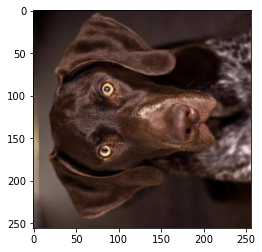

In [3]:
train_b1_img, train_b1_label = next(iter(train_loader))
print('shape of training batch (images): {}'.format(train_b1_img.shape))
print('shape of training batch (labels): {}'.format(train_b1_label.shape))
plt.imshow(train_b1_img[np.random.randint(64)].permute(1,2,0))     #plt.imshow needs the shape to be (x,y,3)
plt.show()

# Model with 6 conv layers

In [5]:
class PetCNN6(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.4),
                                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(128),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=256, out_channels=370, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(370),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(int(370*((size-224)/32)*((size-224)/32)), 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)      # reshaping the output shaped (N,C,H,W) from the conv layer to (N,n_inp) for the dense layer
        out = self.dense1(out)
        out = nn.functional.log_softmax(out,dim=1)     #we'll use the NLL loss, so we used the log softmax function as reqd by pytorch 
        
        return out
    


model1 = PetCNN6()
loss_function = nn.NLLLoss()


print(model1)

learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 160

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.4, inplace=False)
    (1): Conv2d(64, 128,

Epoch:7
Iteration:1400
Time taken for the last 50 iterations: 35.30164957046509
Current training loss:3.0881924629211426
Current training accuracy:0.14111328125
Current validation loss:3.164846658706665
Current validation accuracy:0.14145810902118683
Epoch:7
Iteration:1450
Time taken for the last 50 iterations: 35.04210352897644
Current training loss:3.0121071338653564
Current training accuracy:0.16552734375
Current validation loss:3.0830559730529785
Current validation accuracy:0.15451577305793762
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 34.615936517715454
Current training loss:3.006037950515747
Current training accuracy:0.16748046875
Current validation loss:3.0836353302001953
Current validation accuracy:0.1468988060951233
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 35.293692111968994
Current training loss:2.9402730464935303
Current training accuracy:0.19677734375
Current validation loss:3.013375997543335
Current validation accuracy:0.161044612526

Current validation loss:2.6731958389282227
Current validation accuracy:0.24156692624092102
Epoch:16
Iteration:3050
Time taken for the last 50 iterations: 35.2624454498291
Current training loss:2.592198610305786
Current training accuracy:0.27392578125
Current validation loss:2.7256481647491455
Current validation accuracy:0.2176278531551361
Epoch:16
Iteration:3100
Time taken for the last 50 iterations: 35.0866334438324
Current training loss:2.466723918914795
Current training accuracy:0.31005859375
Current validation loss:2.6265456676483154
Current validation accuracy:0.26877039670944214
Epoch:16
Iteration:3150
Time taken for the last 50 iterations: 35.26818585395813
Current training loss:2.5059900283813477
Current training accuracy:0.32177734375
Current validation loss:2.6586356163024902
Current validation accuracy:0.2502720355987549
Epoch:17
Iteration:3200
Time taken for the last 50 iterations: 35.02633213996887
Current training loss:2.4287760257720947
Current training accuracy:0.317871

Current validation loss:2.3917922973632812
Current validation accuracy:0.32317736744880676
Epoch:25
Iteration:4700
Time taken for the last 50 iterations: 35.490912675857544
Current training loss:2.1793031692504883
Current training accuracy:0.4033203125
Current validation loss:2.42573618888855
Current validation accuracy:0.31556040048599243
Epoch:25
Iteration:4750
Time taken for the last 50 iterations: 35.34904479980469
Current training loss:2.113600015640259
Current training accuracy:0.4189453125
Current validation loss:2.4291696548461914
Current validation accuracy:0.30685529112815857
Epoch:25
Iteration:4800
Time taken for the last 50 iterations: 35.65456223487854
Current training loss:2.1867380142211914
Current training accuracy:0.39453125
Current validation loss:2.4700968265533447
Current validation accuracy:0.28291621804237366
Epoch:26
Iteration:4850
Time taken for the last 50 iterations: 35.032230377197266
Current training loss:2.120893716812134
Current training accuracy:0.4086914

Current training loss:1.8592514991760254
Current training accuracy:0.49365234375
Current validation loss:2.2473559379577637
Current validation accuracy:0.3601740896701813
Epoch:34
Iteration:6350
Time taken for the last 50 iterations: 34.87023448944092
Current training loss:1.91398286819458
Current training accuracy:0.4677734375
Current validation loss:2.3110005855560303
Current validation accuracy:0.33297061920166016
Epoch:34
Iteration:6400
Time taken for the last 50 iterations: 35.43121552467346
Current training loss:1.9151020050048828
Current training accuracy:0.4873046875
Current validation loss:2.3192880153656006
Current validation accuracy:0.32644179463386536
Epoch:34
Iteration:6450
Time taken for the last 50 iterations: 35.501957178115845
Current training loss:1.8164790868759155
Current training accuracy:0.50732421875
Current validation loss:2.2569870948791504
Current validation accuracy:0.3601740896701813
Epoch:34
Iteration:6500
Time taken for the last 50 iterations: 35.51305150

Epoch:42
Iteration:7950
Time taken for the last 50 iterations: 35.374704122543335
Current training loss:1.6651833057403564
Current training accuracy:0.54296875
Current validation loss:2.165517568588257
Current validation accuracy:0.3754080533981323
Epoch:43
Iteration:8000
Time taken for the last 50 iterations: 34.871150493621826
Current training loss:1.6543376445770264
Current training accuracy:0.56396484375
Current validation loss:2.1725568771362305
Current validation accuracy:0.3808487355709076
Epoch:43
Iteration:8050
Time taken for the last 50 iterations: 35.403849363327026
Current training loss:1.7760251760482788
Current training accuracy:0.5185546875
Current validation loss:2.2314250469207764
Current validation accuracy:0.36670294404029846
Epoch:43
Iteration:8100
Time taken for the last 50 iterations: 35.533026933670044
Current training loss:1.6632933616638184
Current training accuracy:0.5693359375
Current validation loss:2.1888272762298584
Current validation accuracy:0.3525571227

Current validation loss:2.1094024181365967
Current validation accuracy:0.3775843381881714
Epoch:51
Iteration:9600
Time taken for the last 50 iterations: 35.284241676330566
Current training loss:1.4445157051086426
Current training accuracy:0.6337890625
Current validation loss:2.0555763244628906
Current validation accuracy:0.40261152386665344
Epoch:51
Iteration:9650
Time taken for the last 50 iterations: 35.169275999069214
Current training loss:1.5147038698196411
Current training accuracy:0.60107421875
Current validation loss:2.1052050590515137
Current validation accuracy:0.3852013051509857
Epoch:52
Iteration:9700
Time taken for the last 50 iterations: 34.65224766731262
Current training loss:1.455453872680664
Current training accuracy:0.63427734375
Current validation loss:2.086214780807495
Current validation accuracy:0.390641987323761
Epoch:52
Iteration:9750
Time taken for the last 50 iterations: 35.403271436691284
Current training loss:1.4679102897644043
Current training accuracy:0.6420

Current training loss:1.3825421333312988
Current training accuracy:0.64599609375
Current validation loss:2.0821609497070312
Current validation accuracy:0.38955387473106384
Epoch:60
Iteration:11250
Time taken for the last 50 iterations: 35.24789881706238
Current training loss:1.3816293478012085
Current training accuracy:0.6552734375
Current validation loss:2.0495386123657227
Current validation accuracy:0.40043526887893677
Epoch:60
Iteration:11300
Time taken for the last 50 iterations: 35.26399540901184
Current training loss:1.393506407737732
Current training accuracy:0.64599609375
Current validation loss:2.0705904960632324
Current validation accuracy:0.3808487355709076
Epoch:61
Iteration:11350
Time taken for the last 50 iterations: 34.68126654624939
Current training loss:1.3239576816558838
Current training accuracy:0.68359375
Current validation loss:2.0740184783935547
Current validation accuracy:0.39934712648391724
Epoch:61
Iteration:11400
Time taken for the last 50 iterations: 35.28822

Epoch:69
Iteration:12850
Time taken for the last 50 iterations: 34.828033208847046
Current training loss:1.3046245574951172
Current training accuracy:0.68359375
Current validation loss:2.059851884841919
Current validation accuracy:0.39281827211380005
Epoch:69
Iteration:12900
Time taken for the last 50 iterations: 34.9087278842926
Current training loss:1.2237297296524048
Current training accuracy:0.70361328125
Current validation loss:2.040506362915039
Current validation accuracy:0.37976062297821045
Epoch:69
Iteration:12950
Time taken for the last 50 iterations: 35.424073219299316
Current training loss:1.2053883075714111
Current training accuracy:0.712890625
Current validation loss:1.9786601066589355
Current validation accuracy:0.418933629989624
Epoch:69
Iteration:13000
Time taken for the last 50 iterations: 35.16776394844055
Current training loss:1.322440266609192
Current training accuracy:0.68505859375
Current validation loss:2.0382297039031982
Current validation accuracy:0.41566920280

Current validation loss:2.000661849975586
Current validation accuracy:0.4341675639152527
Epoch:77
Iteration:14500
Time taken for the last 50 iterations: 35.26935029029846
Current training loss:1.1820275783538818
Current training accuracy:0.74169921875
Current validation loss:1.9949768781661987
Current validation accuracy:0.4243743121623993
Epoch:78
Iteration:14550
Time taken for the last 50 iterations: 34.68916320800781
Current training loss:1.1897149085998535
Current training accuracy:0.75341796875
Current validation loss:1.9964802265167236
Current validation accuracy:0.41675734519958496
Epoch:78
Iteration:14600
Time taken for the last 50 iterations: 35.31214165687561
Current training loss:1.1460946798324585
Current training accuracy:0.74853515625
Current validation loss:1.996391773223877
Current validation accuracy:0.418933629989624
Epoch:78
Iteration:14650
Time taken for the last 50 iterations: 35.396689891815186
Current training loss:1.1805434226989746
Current training accuracy:0.7

Current training loss:1.0939604043960571
Current training accuracy:0.75390625
Current validation loss:1.9850515127182007
Current validation accuracy:0.4178454875946045
Epoch:86
Iteration:16150
Time taken for the last 50 iterations: 35.56374001502991
Current training loss:1.0839701890945435
Current training accuracy:0.759765625
Current validation loss:1.9906176328659058
Current validation accuracy:0.4145810604095459
Epoch:87
Iteration:16200
Time taken for the last 50 iterations: 34.94392728805542
Current training loss:1.1021740436553955
Current training accuracy:0.7626953125
Current validation loss:2.009993076324463
Current validation accuracy:0.40696409344673157
Epoch:87
Iteration:16250
Time taken for the last 50 iterations: 35.3611946105957
Current training loss:1.108582854270935
Current training accuracy:0.75048828125
Current validation loss:1.9829092025756836
Current validation accuracy:0.41675734519958496
Epoch:87
Iteration:16300
Time taken for the last 50 iterations: 35.3897616863

Epoch:95
Iteration:17750
Time taken for the last 50 iterations: 35.441978931427
Current training loss:1.0037915706634521
Current training accuracy:0.7900390625
Current validation loss:1.9673999547958374
Current validation accuracy:0.42981502413749695
Epoch:95
Iteration:17800
Time taken for the last 50 iterations: 35.55202078819275
Current training loss:0.9971701502799988
Current training accuracy:0.802734375
Current validation loss:1.9983617067337036
Current validation accuracy:0.4113166630268097
Epoch:95
Iteration:17850
Time taken for the last 50 iterations: 35.66899561882019
Current training loss:1.063097596168518
Current training accuracy:0.77001953125
Current validation loss:2.0179240703582764
Current validation accuracy:0.40587595105171204
Epoch:96
Iteration:17900
Time taken for the last 50 iterations: 34.996187686920166
Current training loss:1.0147045850753784
Current training accuracy:0.80126953125
Current validation loss:1.9772748947143555
Current validation accuracy:0.41784548

Current validation loss:2.0664780139923096
Current validation accuracy:0.4113166630268097
Epoch:104
Iteration:19400
Time taken for the last 50 iterations: 30.050105333328247
Current training loss:1.0345776081085205
Current training accuracy:0.79443359375
Current validation loss:2.007293224334717
Current validation accuracy:0.41240477561950684
Epoch:104
Iteration:19450
Time taken for the last 50 iterations: 29.715614557266235
Current training loss:1.000247597694397
Current training accuracy:0.80078125
Current validation loss:2.008638620376587
Current validation accuracy:0.418933629989624
Epoch:104
Iteration:19500
Time taken for the last 50 iterations: 29.86765432357788
Current training loss:0.9498221278190613
Current training accuracy:0.81591796875
Current validation loss:2.019012928009033
Current validation accuracy:0.418933629989624
Epoch:105
Iteration:19550
Time taken for the last 50 iterations: 30.110440731048584
Current training loss:1.0206172466278076
Current training accuracy:0.7

Epoch:112
Iteration:21000
Time taken for the last 50 iterations: 29.87986397743225
Current training loss:0.9393383860588074
Current training accuracy:0.8134765625
Current validation loss:2.030197858810425
Current validation accuracy:0.4113166630268097
Epoch:113
Iteration:21050
Time taken for the last 50 iterations: 29.561121463775635
Current training loss:0.9348705410957336
Current training accuracy:0.81591796875
Current validation loss:2.0190699100494385
Current validation accuracy:0.41022852063179016
Epoch:113
Iteration:21100
Time taken for the last 50 iterations: 29.72352170944214
Current training loss:0.9353853464126587
Current training accuracy:0.81640625
Current validation loss:2.024169445037842
Current validation accuracy:0.403699666261673
Epoch:113
Iteration:21150
Time taken for the last 50 iterations: 29.890565395355225
Current training loss:0.9250004291534424
Current training accuracy:0.82421875
Current validation loss:1.9906055927276611
Current validation accuracy:0.42110991

Current validation loss:1.9403886795043945
Current validation accuracy:0.45048967003822327
Epoch:121
Iteration:22650
Time taken for the last 50 iterations: 40.70524311065674
Current training loss:0.9387800097465515
Current training accuracy:0.83251953125
Current validation loss:1.9823222160339355
Current validation accuracy:0.4309031665325165
Epoch:122
Iteration:22700
Time taken for the last 50 iterations: 49.16421318054199
Current training loss:0.909483790397644
Current training accuracy:0.8388671875
Current validation loss:1.9842783212661743
Current validation accuracy:0.418933629989624
Epoch:122
Iteration:22750
Time taken for the last 50 iterations: 42.20985198020935
Current training loss:0.8836998343467712
Current training accuracy:0.83349609375
Current validation loss:1.9649535417556763
Current validation accuracy:0.4211099147796631
Epoch:122
Iteration:22800
Time taken for the last 50 iterations: 41.50789713859558
Current training loss:0.846143364906311
Current training accuracy:0

KeyboardInterrupt: 

Need to run it for longer.

In [6]:
num_epochs = 100

iteration = 0


start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

Epoch:0
Iteration:50
Time taken for the last 50 iterations: 35.81721758842468
Epoch:0
Iteration:100
Time taken for the last 50 iterations: 38.64091730117798
Epoch:0
Iteration:150
Time taken for the last 50 iterations: 40.639864444732666
Epoch:1
Iteration:200
Time taken for the last 50 iterations: 39.820897340774536
Current training loss:0.8889734745025635
Current training accuracy:0.82666015625
Current validation loss:2.0195212364196777
Current validation accuracy:0.4211099147796631
Epoch:1
Iteration:250
Time taken for the last 50 iterations: 37.20583128929138
Current training loss:0.8757378458976746
Current training accuracy:0.83984375
Current validation loss:2.004446506500244
Current validation accuracy:0.42219802737236023
Epoch:1
Iteration:300
Time taken for the last 50 iterations: 34.124826192855835
Current training loss:0.8457779288291931
Current training accuracy:0.84033203125
Current validation loss:2.011007070541382
Current validation accuracy:0.4309031665325165
Epoch:1
Iterati

Epoch:9
Iteration:1800
Time taken for the last 50 iterations: 30.100584030151367
Current training loss:0.8474485874176025
Current training accuracy:0.8505859375
Current validation loss:1.973535418510437
Current validation accuracy:0.41566920280456543
Epoch:9
Iteration:1850
Time taken for the last 50 iterations: 29.63466501235962
Current training loss:0.8898953795433044
Current training accuracy:0.84375
Current validation loss:1.9925750494003296
Current validation accuracy:0.43960827589035034
Epoch:10
Iteration:1900
Time taken for the last 50 iterations: 29.18603515625
Current training loss:0.7983275055885315
Current training accuracy:0.85791015625
Current validation loss:1.9459879398345947
Current validation accuracy:0.4374319911003113
Epoch:10
Iteration:1950
Time taken for the last 50 iterations: 29.704667329788208
Current training loss:0.8084105253219604
Current training accuracy:0.85693359375
Current validation loss:1.9353132247924805
Current validation accuracy:0.44287267327308655


Current validation loss:1.9523900747299194
Current validation accuracy:0.4287268817424774
Epoch:18
Iteration:3450
Time taken for the last 50 iterations: 29.637165546417236
Current training loss:0.81267249584198
Current training accuracy:0.8564453125
Current validation loss:1.917680025100708
Current validation accuracy:0.42981502413749695
Epoch:18
Iteration:3500
Time taken for the last 50 iterations: 30.14003014564514
Current training loss:0.7647892236709595
Current training accuracy:0.8798828125
Current validation loss:1.876012921333313
Current validation accuracy:0.45919477939605713
Epoch:19
Iteration:3550
Time taken for the last 50 iterations: 29.581607580184937
Current training loss:0.8352587819099426
Current training accuracy:0.85791015625
Current validation loss:1.9821242094039917
Current validation accuracy:0.418933629989624
Epoch:19
Iteration:3600
Time taken for the last 50 iterations: 29.95342707633972
Current training loss:0.7983585596084595
Current training accuracy:0.8598632

Current training loss:0.8189786672592163
Current training accuracy:0.86083984375
Current validation loss:1.9698565006256104
Current validation accuracy:0.431991308927536
Epoch:27
Iteration:5100
Time taken for the last 50 iterations: 29.640166997909546
Current training loss:0.7446141242980957
Current training accuracy:0.88818359375
Current validation loss:1.9097490310668945
Current validation accuracy:0.4417845606803894
Epoch:27
Iteration:5150
Time taken for the last 50 iterations: 29.72314429283142
Current training loss:0.8467002511024475
Current training accuracy:0.83984375
Current validation loss:1.955344557762146
Current validation accuracy:0.4374319911003113
Epoch:27
Iteration:5200
Time taken for the last 50 iterations: 29.973089933395386
Current training loss:0.7485653162002563
Current training accuracy:0.888671875
Current validation loss:1.8938294649124146
Current validation accuracy:0.454842209815979
Epoch:28
Iteration:5250
Time taken for the last 50 iterations: 29.3186359405517

Epoch:36
Iteration:6700
Time taken for the last 50 iterations: 29.41990613937378
Current training loss:0.7236270904541016
Current training accuracy:0.88134765625
Current validation loss:1.9277265071868896
Current validation accuracy:0.4483133852481842
Epoch:36
Iteration:6750
Time taken for the last 50 iterations: 29.758866548538208
Current training loss:0.7683478593826294
Current training accuracy:0.8662109375
Current validation loss:1.9390100240707397
Current validation accuracy:0.43634384870529175
Epoch:36
Iteration:6800
Time taken for the last 50 iterations: 29.65706968307495
Current training loss:0.7693197131156921
Current training accuracy:0.86572265625
Current validation loss:1.9690845012664795
Current validation accuracy:0.4341675639152527
Epoch:36
Iteration:6850
Time taken for the last 50 iterations: 29.692358016967773
Current training loss:0.7331088185310364
Current training accuracy:0.8837890625
Current validation loss:1.9330112934112549
Current validation accuracy:0.43307942

Current validation loss:1.9386348724365234
Current validation accuracy:0.4537540674209595
Epoch:44
Iteration:8350
Time taken for the last 50 iterations: 29.906550884246826
Current training loss:0.7061245441436768
Current training accuracy:0.88720703125
Current validation loss:1.924651026725769
Current validation accuracy:0.4472252428531647
Epoch:45
Iteration:8400
Time taken for the last 50 iterations: 29.56429648399353
Current training loss:0.7311528325080872
Current training accuracy:0.88037109375
Current validation loss:1.9585192203521729
Current validation accuracy:0.44287267327308655
Epoch:45
Iteration:8450
Time taken for the last 50 iterations: 29.97221040725708
Current training loss:0.7527263164520264
Current training accuracy:0.88427734375
Current validation loss:1.9383691549301147
Current validation accuracy:0.43960827589035034
Epoch:45
Iteration:8500
Time taken for the last 50 iterations: 29.90368127822876
Current training loss:0.7075554132461548
Current training accuracy:0.88

Current training loss:0.6830203533172607
Current training accuracy:0.9072265625
Current validation loss:1.9207535982131958
Current validation accuracy:0.45266595482826233
Epoch:53
Iteration:10000
Time taken for the last 50 iterations: 29.909518480300903
Current training loss:0.7307206988334656
Current training accuracy:0.89892578125
Current validation loss:1.9244450330734253
Current validation accuracy:0.4472252428531647
Epoch:54
Iteration:10050
Time taken for the last 50 iterations: 29.151588916778564
Current training loss:0.6835319399833679
Current training accuracy:0.90478515625
Current validation loss:1.9652551412582397
Current validation accuracy:0.431991308927536
Epoch:54
Iteration:10100
Time taken for the last 50 iterations: 29.913867235183716
Current training loss:0.7027596235275269
Current training accuracy:0.8798828125
Current validation loss:1.9537200927734375
Current validation accuracy:0.41675734519958496
Epoch:54
Iteration:10150
Time taken for the last 50 iterations: 29.9

Epoch:62
Iteration:11600
Time taken for the last 50 iterations: 29.955103635787964
Current training loss:0.654632031917572
Current training accuracy:0.90771484375
Current validation loss:1.9242700338363647
Current validation accuracy:0.4450489580631256
Epoch:62
Iteration:11650
Time taken for the last 50 iterations: 29.541866540908813
Current training loss:0.734514594078064
Current training accuracy:0.88037109375
Current validation loss:1.9661059379577637
Current validation accuracy:0.41675734519958496
Epoch:62
Iteration:11700
Time taken for the last 50 iterations: 29.719693183898926
Current training loss:0.7151837348937988
Current training accuracy:0.8955078125
Current validation loss:1.9237898588180542
Current validation accuracy:0.4483133852481842
Epoch:63
Iteration:11750
Time taken for the last 50 iterations: 29.15921664237976
Current training loss:0.7177151441574097
Current training accuracy:0.87646484375
Current validation loss:1.9448390007019043
Current validation accuracy:0.4363

Current validation loss:1.9607181549072266
Current validation accuracy:0.4287268817424774
Epoch:71
Iteration:13250
Time taken for the last 50 iterations: 29.45410680770874
Current training loss:0.6993952393531799
Current training accuracy:0.89794921875
Current validation loss:1.918129324913025
Current validation accuracy:0.44940152764320374
Epoch:71
Iteration:13300
Time taken for the last 50 iterations: 29.77049231529236
Current training loss:0.7095698118209839
Current training accuracy:0.884765625
Current validation loss:2.014047145843506
Current validation accuracy:0.4178454875946045
Epoch:71
Iteration:13350
Time taken for the last 50 iterations: 29.99945592880249
Current training loss:0.6830806732177734
Current training accuracy:0.90771484375
Current validation loss:1.9805492162704468
Current validation accuracy:0.43960827589035034
Epoch:72
Iteration:13400
Time taken for the last 50 iterations: 29.764376401901245
Current training loss:0.7244148850440979
Current training accuracy:0.8

Current training loss:0.709965169429779
Current training accuracy:0.89013671875
Current validation loss:2.0149340629577637
Current validation accuracy:0.4243743121623993
Epoch:80
Iteration:14900
Time taken for the last 50 iterations: 29.568032264709473
Current training loss:0.6764389872550964
Current training accuracy:0.90283203125
Current validation loss:1.9599409103393555
Current validation accuracy:0.4276387393474579
Epoch:80
Iteration:14950
Time taken for the last 50 iterations: 29.828738689422607
Current training loss:0.6448317170143127
Current training accuracy:0.91845703125
Current validation loss:1.9376643896102905
Current validation accuracy:0.4439608156681061
Epoch:80
Iteration:15000
Time taken for the last 50 iterations: 30.064938068389893
Current training loss:0.6700415015220642
Current training accuracy:0.904296875
Current validation loss:1.9824286699295044
Current validation accuracy:0.4287268817424774
Epoch:80
Iteration:15050
Time taken for the last 50 iterations: 30.373

Epoch:88
Iteration:16500
Time taken for the last 50 iterations: 29.8134982585907
Current training loss:0.6726967096328735
Current training accuracy:0.91357421875
Current validation loss:1.939443826675415
Current validation accuracy:0.4417845606803894
Epoch:88
Iteration:16550
Time taken for the last 50 iterations: 30.181310415267944
Current training loss:0.6376574635505676
Current training accuracy:0.9111328125
Current validation loss:1.9489959478378296
Current validation accuracy:0.4385201334953308
Epoch:89
Iteration:16600
Time taken for the last 50 iterations: 29.799293279647827
Current training loss:0.6290068626403809
Current training accuracy:0.91796875
Current validation loss:1.9187573194503784
Current validation accuracy:0.467899888753891
Epoch:89
Iteration:16650
Time taken for the last 50 iterations: 29.89496898651123
Current training loss:0.6685758829116821
Current training accuracy:0.91259765625
Current validation loss:1.9140082597732544
Current validation accuracy:0.4613710641

Current validation loss:1.9202715158462524
Current validation accuracy:0.4417845606803894
Epoch:97
Iteration:18150
Time taken for the last 50 iterations: 29.8929443359375
Current training loss:0.5833951830863953
Current training accuracy:0.92822265625
Current validation loss:1.945085048675537
Current validation accuracy:0.4309031665325165
Epoch:97
Iteration:18200
Time taken for the last 50 iterations: 30.22113823890686
Current training loss:0.6503241658210754
Current training accuracy:0.9130859375
Current validation loss:1.9919281005859375
Current validation accuracy:0.4276387393474579
Epoch:98
Iteration:18250
Time taken for the last 50 iterations: 29.68745708465576
Current training loss:0.6744581460952759
Current training accuracy:0.9111328125
Current validation loss:1.9787465333938599
Current validation accuracy:0.42002177238464355
Epoch:98
Iteration:18300
Time taken for the last 50 iterations: 30.104475259780884
Current training loss:0.6302016377449036
Current training accuracy:0.91

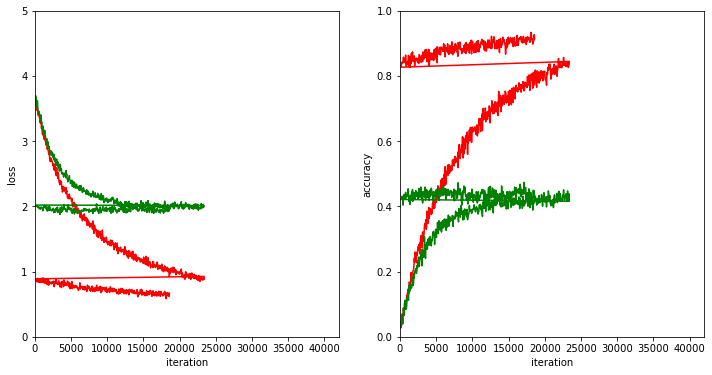

In [7]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,42000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,42000)
acc_graph.set_ylim(0,1)

plt.show() 

# Model with 6 conv and 2 dense layers

In [13]:
class PetCNN6ch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
                                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(8),
                                    nn.ReLU())
        
        self.conv2 = nn.Sequential( nn.Dropout2d(0.2),
                                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=4,stride=2),                                    
                                    nn.BatchNorm2d(16),
                                    nn.ReLU())
        
        self.conv3 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
        
        self.conv4 = nn.Sequential( nn.Dropout2d(0.3),
                                    nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
        
        self.conv5 = nn.Sequential( nn.Dropout(0.3),
                                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=2),                                    
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        
        self.conv6 = nn.Sequential( nn.Dropout(0.4),
                                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3),
                                    nn.MaxPool2d(kernel_size=3,stride=1),                                    
                                    nn.BatchNorm2d(1024),
                                    nn.ReLU())
        
        self.dense1 = nn.Sequential(nn.Dropout(0.4),
                                    nn.Linear(1024, 370))
        
        self.dense2 = nn.Sequential(nn.Dropout(0.3),
                                    nn.Linear(370, 37))
                    
        
                       
            
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.view(out.size(0),-1)     
        out = self.dense1(out)
        out = self.dense2(out)
        out = nn.functional.log_softmax(out,dim=1)    
        
        return out
    


model1 = PetCNN6ch()
loss_function = nn.NLLLoss()


print(model1)
        


learning_rate = 0.001
decay_rate = 0.0003
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate, weight_decay=decay_rate)

num_epochs = 90

iteration = 0
iteration_list = []
train_loss_iter=[]
train_accuracy_iter=[]
valid_loss_iter=[]
valid_accuracy_iter=[]




start = time.time()

#for i in range(num_epochs):
for epoch in range(num_epochs):
    for images, labels in train_loader:
        model1.train()
        out = model1(images.float())
        loss = loss_function(out,labels)
        
        optimizer.zero_grad()
        loss.backward()
        
        #for name, param in model.named_parameters():         # this is just to check if the parameters are getting valid gradients
            #print(name, param.grad.abs().sum())
    
        optimizer.step()
        
        iteration += 1
        
        
        if iteration%50==0:
            
            end = time.time()
            print('Epoch:{}'.format(epoch))
            print('Iteration:{}'.format(iteration))
            print('Time taken for the last 50 iterations: {}'.format(end-start))
            
            
            if epoch>0:      # after the first epoch, every 50th iteration is a checkpoint
                model1.eval()
                with torch.no_grad():
                    train_part = DataLoader(train,batch_size=2048,shuffle=True)   # a random batch from the training set 1
                    images_c, labels_c = next(iter(train_part))
                    train_out = model1(images_c.float())    # we're calculating the training accuracy on this random batch
                    current_train_loss = loss_function(train_out,labels_c)
                    current_train_accuracy = (torch.max(train_out,1)[1]==labels_c).sum()/2048
                    print('Current training loss:{}'.format(current_train_loss))
                    print('Current training accuracy:{}'.format(current_train_accuracy))

                    valid_entire = next(iter(valid_loader))
                    valid_out = model1(valid_entire[0].float())
                    current_valid_loss = loss_function(valid_out,valid_entire[1])
                    current_valid_accuracy = (torch.max(valid_out,1)[1]==valid_entire[1]).sum()/len(valid)
                    print('Current validation loss:{}'.format(current_valid_loss))
                    print('Current validation accuracy:{}'.format(current_valid_accuracy))

                    train_loss_iter.append(current_train_loss)
                    train_accuracy_iter.append(current_train_accuracy)
                    valid_loss_iter.append(current_valid_loss)
                    valid_accuracy_iter.append(current_valid_accuracy)
                    iteration_list.append(iteration)

                
            
            start = time.time()
                

            
        

    


PetCNN6ch(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2): Sequential(
    (0): Dropout2d(p=0.2, inplace=False)
    (1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv3): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
  )
  (conv4): Sequential(
    (0): Dropout2d(p=0.3, inplace=False)
    (1): Conv2d(64, 25

Current validation loss:2.8429529666900635
Current validation accuracy:0.21871599555015564
Epoch:7
Iteration:1400
Time taken for the last 50 iterations: 59.62431573867798
Current training loss:2.677136182785034
Current training accuracy:0.24072265625
Current validation loss:2.8207523822784424
Current validation accuracy:0.20021763443946838
Epoch:7
Iteration:1450
Time taken for the last 50 iterations: 60.05659031867981
Current training loss:2.6864099502563477
Current training accuracy:0.2353515625
Current validation loss:2.816845417022705
Current validation accuracy:0.20674645900726318
Epoch:8
Iteration:1500
Time taken for the last 50 iterations: 59.26530313491821
Current training loss:2.703524589538574
Current training accuracy:0.2451171875
Current validation loss:2.75785756111145
Current validation accuracy:0.22306855022907257
Epoch:8
Iteration:1550
Time taken for the last 50 iterations: 59.71871042251587
Current training loss:2.708784818649292
Current training accuracy:0.23095703125


Current validation loss:2.254551649093628
Current validation accuracy:0.34929269552230835
Epoch:16
Iteration:3050
Time taken for the last 50 iterations: 59.83489370346069
Current training loss:1.91010320186615
Current training accuracy:0.4521484375
Current validation loss:2.2738475799560547
Current validation accuracy:0.33623504638671875
Epoch:16
Iteration:3100
Time taken for the last 50 iterations: 59.80659341812134
Current training loss:1.8639994859695435
Current training accuracy:0.46923828125
Current validation loss:2.327118158340454
Current validation accuracy:0.33949944376945496
Epoch:16
Iteration:3150
Time taken for the last 50 iterations: 59.33193254470825
Current training loss:1.787301778793335
Current training accuracy:0.49560546875
Current validation loss:2.235077142715454
Current validation accuracy:0.3449401557445526
Epoch:17
Iteration:3200
Time taken for the last 50 iterations: 58.94226431846619
Current training loss:1.8250243663787842
Current training accuracy:0.48388671

Current validation loss:2.11506986618042
Current validation accuracy:0.3917301297187805
Epoch:25
Iteration:4700
Time taken for the last 50 iterations: 62.4909451007843
Current training loss:1.1448644399642944
Current training accuracy:0.7001953125
Current validation loss:2.0671138763427734
Current validation accuracy:0.39608269929885864
Epoch:25
Iteration:4750
Time taken for the last 50 iterations: 62.754077434539795
Current training loss:1.306794285774231
Current training accuracy:0.6455078125
Current validation loss:2.1295814514160156
Current validation accuracy:0.3917301297187805
Epoch:25
Iteration:4800
Time taken for the last 50 iterations: 82.05632472038269
Current training loss:1.1949715614318848
Current training accuracy:0.70556640625
Current validation loss:2.0827789306640625
Current validation accuracy:0.38955387473106384
Epoch:26
Iteration:4850
Time taken for the last 50 iterations: 59.7894651889801
Current training loss:1.197290062904358
Current training accuracy:0.698730468

Current training loss:0.7700700163841248
Current training accuracy:0.818359375
Current validation loss:2.0995216369628906
Current validation accuracy:0.4047878086566925
Epoch:34
Iteration:6350
Time taken for the last 50 iterations: 65.62745428085327
Current training loss:0.7758620381355286
Current training accuracy:0.84765625
Current validation loss:2.015197992324829
Current validation accuracy:0.43307942152023315
Epoch:34
Iteration:6400
Time taken for the last 50 iterations: 66.81381106376648
Current training loss:0.794243335723877
Current training accuracy:0.82666015625
Current validation loss:2.044301986694336
Current validation accuracy:0.418933629989624
Epoch:34
Iteration:6450
Time taken for the last 50 iterations: 68.42623662948608
Current training loss:0.7433184385299683
Current training accuracy:0.83984375
Current validation loss:2.0055387020111084
Current validation accuracy:0.4254624545574188
Epoch:34
Iteration:6500
Time taken for the last 50 iterations: 67.36771202087402
Cur

Current training loss:0.5140131115913391
Current training accuracy:0.90869140625
Current validation loss:2.0021626949310303
Current validation accuracy:0.4341675639152527
Epoch:43
Iteration:8000
Time taken for the last 50 iterations: 67.00011014938354
Current training loss:0.5098909139633179
Current training accuracy:0.90283203125
Current validation loss:2.0124194622039795
Current validation accuracy:0.4341675639152527
Epoch:43
Iteration:8050
Time taken for the last 50 iterations: 67.24753093719482
Current training loss:0.5286422967910767
Current training accuracy:0.90966796875
Current validation loss:2.0210564136505127
Current validation accuracy:0.4341675639152527
Epoch:43
Iteration:8100
Time taken for the last 50 iterations: 63.483447551727295
Current training loss:0.5264113545417786
Current training accuracy:0.908203125
Current validation loss:2.0342674255371094
Current validation accuracy:0.4472252428531647
Epoch:43
Iteration:8150
Time taken for the last 50 iterations: 52.18914747

Epoch:51
Iteration:9600
Time taken for the last 50 iterations: 54.621681928634644
Current training loss:0.39536210894584656
Current training accuracy:0.93359375
Current validation loss:2.0572643280029297
Current validation accuracy:0.42219802737236023
Epoch:51
Iteration:9650
Time taken for the last 50 iterations: 54.74389624595642
Current training loss:0.3393386900424957
Current training accuracy:0.9541015625
Current validation loss:2.04296612739563
Current validation accuracy:0.44287267327308655
Epoch:52
Iteration:9700
Time taken for the last 50 iterations: 53.77667212486267
Current training loss:0.3477936387062073
Current training accuracy:0.94873046875
Current validation loss:2.032123565673828
Current validation accuracy:0.4472252428531647
Epoch:52
Iteration:9750
Time taken for the last 50 iterations: 55.44692540168762
Current training loss:0.3943350911140442
Current training accuracy:0.9423828125
Current validation loss:2.090733766555786
Current validation accuracy:0.42437431216239

Current validation loss:2.107741117477417
Current validation accuracy:0.4287268817424774
Epoch:60
Iteration:11250
Time taken for the last 50 iterations: 68.1913673877716
Current training loss:0.29183802008628845
Current training accuracy:0.95947265625
Current validation loss:2.0924482345581055
Current validation accuracy:0.431991308927536
Epoch:60
Iteration:11300
Time taken for the last 50 iterations: 69.02811050415039
Current training loss:0.25243741273880005
Current training accuracy:0.9716796875
Current validation loss:2.0091967582702637
Current validation accuracy:0.44940152764320374
Epoch:61
Iteration:11350
Time taken for the last 50 iterations: 68.12099242210388
Current training loss:0.27920112013816833
Current training accuracy:0.9677734375
Current validation loss:2.0893969535827637
Current validation accuracy:0.4211099147796631
Epoch:61
Iteration:11400
Time taken for the last 50 iterations: 69.69478344917297
Current training loss:0.26992446184158325
Current training accuracy:0.

Current training loss:0.20238690078258514
Current training accuracy:0.98046875
Current validation loss:2.072824716567993
Current validation accuracy:0.44287267327308655
Epoch:69
Iteration:12900
Time taken for the last 50 iterations: 108.66273856163025
Current training loss:0.1899896115064621
Current training accuracy:0.978515625
Current validation loss:2.085620880126953
Current validation accuracy:0.46028292179107666
Epoch:69
Iteration:12950
Time taken for the last 50 iterations: 110.14366912841797
Current training loss:0.21070876717567444
Current training accuracy:0.97265625
Current validation loss:2.046358585357666
Current validation accuracy:0.45048967003822327
Epoch:69
Iteration:13000
Time taken for the last 50 iterations: 112.0677421092987
Current training loss:0.23339933156967163
Current training accuracy:0.9697265625
Current validation loss:2.140507698059082
Current validation accuracy:0.4341675639152527
Epoch:70
Iteration:13050
Time taken for the last 50 iterations: 112.4116928

Epoch:77
Iteration:14500
Time taken for the last 50 iterations: 163.05360794067383
Current training loss:0.17680013179779053
Current training accuracy:0.9853515625
Current validation loss:2.0736522674560547
Current validation accuracy:0.4450489580631256
Epoch:78
Iteration:14550
Time taken for the last 50 iterations: 162.19830703735352
Current training loss:0.17719410359859467
Current training accuracy:0.97607421875
Current validation loss:2.0941479206085205
Current validation accuracy:0.4450489580631256
Epoch:78
Iteration:14600
Time taken for the last 50 iterations: 166.3988025188446
Current training loss:0.17026492953300476
Current training accuracy:0.98193359375
Current validation loss:2.0854172706604004
Current validation accuracy:0.4439608156681061
Epoch:78
Iteration:14650
Time taken for the last 50 iterations: 168.2709035873413
Current training loss:0.16511572897434235
Current training accuracy:0.986328125
Current validation loss:2.033094882965088
Current validation accuracy:0.455

Current validation loss:2.106653928756714
Current validation accuracy:0.4385201334953308
Epoch:86
Iteration:16150
Time taken for the last 50 iterations: 185.13750195503235
Current training loss:0.14724446833133698
Current training accuracy:0.986328125
Current validation loss:2.183155059814453
Current validation accuracy:0.4374319911003113
Epoch:87
Iteration:16200
Time taken for the last 50 iterations: 182.1412227153778
Current training loss:0.1647125631570816
Current training accuracy:0.984375
Current validation loss:2.122976779937744
Current validation accuracy:0.4406964182853699
Epoch:87
Iteration:16250
Time taken for the last 50 iterations: 184.21508836746216
Current training loss:0.15569926798343658
Current training accuracy:0.98193359375
Current validation loss:2.2286155223846436
Current validation accuracy:0.4287268817424774
Epoch:87
Iteration:16300
Time taken for the last 50 iterations: 184.2414047718048
Current training loss:0.12905892729759216
Current training accuracy:0.98779

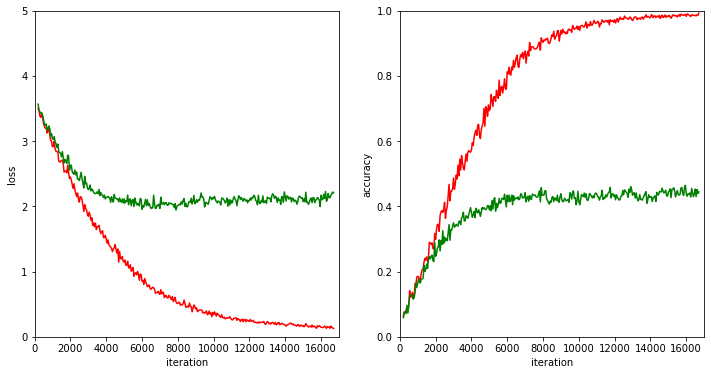

In [14]:
fig = plt.figure(figsize=(12,6))

loss_graph = fig.add_subplot(1,2,1)
loss_graph.plot(iteration_list, train_loss_iter, 'r-')[0]    # the [0] to get the first element of the tuple returned
loss_graph.plot(iteration_list, valid_loss_iter,'g-')[0]
loss_graph.set_xlabel('iteration')
loss_graph.set_ylabel('loss')
loss_graph.set_xlim(0,17000)
loss_graph.set_ylim(0,5)

acc_graph = fig.add_subplot(1,2,2)
acc_graph.plot(iteration_list,train_accuracy_iter, 'r-')[0]
acc_graph.plot(iteration_list, valid_accuracy_iter,'g-')[0]
acc_graph.set_xlabel('iteration')
acc_graph.set_ylabel('accuracy')
acc_graph.set_xlim(0,17000)
acc_graph.set_ylim(0,1)

plt.show() 